In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd

# Example path — change this to your file's path
file_path = '/content/drive/MyDrive//BTP/main.csv'

df = pd.read_csv(file_path)

df.head()


,datetime,Load(KWH)
0,2023-07-01 00:00:00,11.23
1,2023-07-01 00:30:00,11.06
2,2023-07-01 01:00:00,10.76
3,2023-07-01 01:30:00,10.75
4,2023-07-01 02:00:00,10.61


In [14]:
import pandas as pd

# Load your CSV
file_path = '/content/drive/MyDrive/BTP/main.csv'
df = pd.read_csv(file_path, parse_dates=['datetime'])

# Extract month temporarily
df['month'] = df['datetime'].dt.month

# ---- PART 1: July (7) to October (10) ----
df_part1 = df[(df['month'] >= 7) & (df['month'] <= 10)].copy()
df_part1 = df_part1.drop(columns=['month'])   # remove month
df_part1.to_csv('/content/drive/MyDrive/BTP/main_part1_Jul_Oct.csv', index=False)

# ---- PART 2: November (11) to February (2) ----
df_part2 = df[(df['month'] >= 11) | (df['month'] <= 2)].copy()
df_part2 = df_part2.drop(columns=['month'])   # remove month
df_part2.to_csv('/content/drive/MyDrive/BTP/main_part2_Nov_Feb.csv', index=False)

# ---- PART 3: March (3) to June (6) ----
df_part3 = df[(df['month'] >= 3) & (df['month'] <= 6)].copy()
df_part3 = df_part3.drop(columns=['month'])   # remove month
df_part3.to_csv('/content/drive/MyDrive/BTP/main_part3_Mar_Jun.csv', index=False)

df_part1.head(), df_part2.head(), df_part3.head()


(             datetime  Load(KWH)
 0 2023-07-01 00:00:00      11.23
 1 2023-07-01 00:30:00      11.06
 2 2023-07-01 01:00:00      10.76
 3 2023-07-01 01:30:00      10.75
 4 2023-07-01 02:00:00      10.61,
                 datetime  Load(KWH)
 5904 2023-11-01 00:00:00      10.03
 5905 2023-11-01 00:30:00       9.89
 5906 2023-11-01 01:00:00       9.74
 5907 2023-11-01 01:30:00       9.82
 5908 2023-11-01 02:00:00       9.77,
                  datetime  Load(KWH)
 11712 2024-03-01 00:00:00       7.10
 11713 2024-03-01 00:30:00       6.87
 11714 2024-03-01 01:00:00       6.74
 11715 2024-03-01 01:30:00       6.54
 11716 2024-03-01 02:00:00       6.38)

In [16]:
import pandas as pd

# Input files (the ones you created earlier)
in_files = {
    'part1': '/content/drive/MyDrive/BTP/main_part1_Jul_Oct.csv',
    'part2': '/content/drive/MyDrive/BTP/main_part2_Nov_Feb.csv',
    'part3': '/content/drive/MyDrive/BTP/main_part3_Mar_Jun.csv'
}

# Output files (pivoted)
out_files = {
    'part1': '/content/drive/MyDrive/BTP/main_part1_Jul_Oct_pivot.csv',
    'part2': '/content/drive/MyDrive/BTP/main_part2_Nov_Feb_pivot.csv',
    'part3': '/content/drive/MyDrive/BTP/main_part3_Mar_Jun_pivot.csv'
}

# Generate all 48 time columns (00:00–23:30)
time_slots = pd.date_range('00:00', '23:30', freq='30T').strftime('%H:%M').tolist()

for key in in_files:
    df = pd.read_csv(in_files[key], parse_dates=['datetime'])

    # Create date and time
    df['date'] = df['datetime'].dt.date.astype(str)
    df['time'] = df['datetime'].dt.strftime('%H:%M')

    # Pivot the table
    pivot = df.pivot_table(index='date',
                           columns='time',
                           values='Load(KWH)',
                           aggfunc='first')

    # Ensure all columns are present in correct order
    pivot = pivot.reindex(columns=time_slots)

    # Reset index so 'date' becomes a normal column
    pivot = pivot.reset_index()

    # Save final CSV
    pivot.to_csv(out_files[key], index=False)

    print(f"Saved -> {out_files[key]}  shape={pivot.shape}")


/tmp/ipython-input-3190014111.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_slots = pd.date_range('00:00', '23:30', freq='30T').strftime('%H:%M').tolist()


Saved -> /content/drive/MyDrive/BTP/main_part1_Jul_Oct_pivot.csv  shape=(123, 49)
Saved -> /content/drive/MyDrive/BTP/main_part2_Nov_Feb_pivot.csv  shape=(121, 49)
Saved -> /content/drive/MyDrive/BTP/main_part3_Mar_Jun_pivot.csv  shape=(122, 49)


In [19]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/BTP/main.csv', parse_dates=['datetime'])

# Highest value and when it occurred
max_value = df['Load(KWH)'].max()
max_time = df.loc[df['Load(KWH)'].idxmax(), 'datetime']

# Lowest value and when it occurred
min_value = df['Load(KWH)'].min()
min_time = df.loc[df['Load(KWH)'].idxmin(), 'datetime']

max_value, max_time, min_value, min_time


(20.53,
 Timestamp('2024-05-28 18:00:00'),
 0.0,
 Timestamp('2023-07-11 01:30:00'))

In [20]:
import pandas as pd
import numpy as np
import string

# PARAMETERS (change if you want)
file_path = '/content/drive/MyDrive/BTP/main.csv'   # original file
w = 12      # number of PAA segments per day (must divide or be <= 48)
a = 8       # alphabet size (# letters), e.g., 3..26. Default 8 -> letters 'a'..'h'

# --- 1) Read and pivot into per-day sequences (48 columns) ---
df = pd.read_csv(file_path, parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date.astype(str)
df['time'] = df['datetime'].dt.strftime('%H:%M')

# pivot so each row = one date, columns = 48 time slots
time_slots = pd.date_range('00:00','23:30',freq='30T').strftime('%H:%M').tolist()
pivot = df.pivot_table(index='date', columns='time', values='Load(KWH)', aggfunc='first')
pivot = pivot.reindex(columns=time_slots).sort_index()   # ensure all 48 cols & order

# drop dates that do not have any non-null values (optional)
pivot = pivot.dropna(how='all')

# convert to numpy array for faster ops (rows x 48)
data = pivot.values.astype(float)   # shape (n_days, 48)

# --- helper: PAA function ---
def paa_transform(series, segments):
    """
    series: 1D numpy array of length L (should be 48)
    segments: int w <= L
    returns: 1D numpy array of length 'segments' (PAA)
    """
    L = len(series)
    if segments == L:
        return series.copy()
    # compute frame size (may be fractional); use equal-length frames
    frame_size = L / segments
    paa = np.zeros(segments, dtype=float)
    for i in range(segments):
        start = int(np.round(i * frame_size))
        end = int(np.round((i+1) * frame_size))
        if end <= start:
            end = start + 1
        # ensure we don't go out of bounds
        end = min(end, L)
        block = series[start:end]
        if block.size == 0:
            paa[i] = 0.0
        else:
            paa[i] = block.mean()
    return paa

# --- 2) Normalize each day (z-score) and compute PAA for each day ---
eps = 1e-9
n_days = data.shape[0]
paa_matrix = np.zeros((n_days, w), dtype=float)
for i in range(n_days):
    day = data[i, :]
    # if entire day is NaN, keep NaNs
    if np.all(np.isnan(day)):
        paa_matrix[i, :] = np.nan
        continue
    # normalize: z-score (mean 0, std 1); if std==0 -> zeros
    valid = ~np.isnan(day)
    mean = np.nanmean(day)
    std = np.nanstd(day)
    if std < eps:
        norm_day = np.zeros_like(day)
    else:
        norm_day = (day - mean) / std
    # for any remaining NaNs (holes), you can forward-fill/backfill or set to 0
    # here we replace NaNs with the day's mean before PAA (common option)
    norm_day[np.isnan(norm_day)] = 0.0
    paa = paa_transform(norm_day, w)
    paa_matrix[i, :] = paa

# --- 3) Build quantile-based breakpoints using all PAA values ---
# Flatten PAA values and drop NaNs
flat = paa_matrix.flatten()
flat = flat[~np.isnan(flat)]

# We need a-1 breakpoints: the quantiles at 1/a, 2/a, ..., (a-1)/a
quantiles = [(k / a) for k in range(1, a)]
breakpoints = np.quantile(flat, quantiles).tolist()  # length a-1

# --- 4) Map PAA segments to letters using the breakpoints ---
alphabet = list(string.ascii_lowercase[:a])   # e.g., ['a','b',...]
def map_to_letters(paa_vec, breakpoints, alphabet):
    # for each value -> find index of interval
    letters = []
    for val in paa_vec:
        if np.isnan(val):
            letters.append('?')   # placeholder for missing
            continue
        # find the first breakpoint greater than val
        idx = np.searchsorted(breakpoints, val, side='right')
        # idx in [0..a-1]
        letters.append(alphabet[idx])
    return ''.join(letters)

words = []
for i in range(n_days):
    word = map_to_letters(paa_matrix[i, :], breakpoints, alphabet)
    words.append(word)

# --- 5) Save results: date, SAX word, optionally PAA columns ---
out_df = pd.DataFrame({'date': pivot.index, 'sax_word': words})
# also attach PAA columns if you want
paa_cols = [f'PAA_{j+1}' for j in range(w)]
paa_df = pd.DataFrame(paa_matrix, columns=paa_cols, index=pivot.index).reset_index(drop=True)
out_df = pd.concat([out_df.reset_index(drop=True), paa_df], axis=1)

out_path = '/content/drive/MyDrive/BTP/daily_sax_words.csv'
out_df.to_csv(out_path, index=False)
print("Saved SAX words ->", out_path)

# also print the breakpoints and letter mapping for clarity
print("\nAlphabet size a =", a)
print("Letters used:", alphabet)
print("Breakpoints (a-1 values):", breakpoints)
print("Mapping intervals (letter : interval):")
intervals = []
left = -np.inf
for i, bp in enumerate(breakpoints):
    right = bp
    intervals.append((alphabet[i], (left, right)))
    left = bp
intervals.append((alphabet[-1], (left, np.inf)))
for letter, (L, R) in intervals:
    print(f"  {letter} : ({L:.4f}, {R:.4f})")


Saved SAX words -> /content/drive/MyDrive/BTP/daily_sax_words.csv

Alphabet size a = 8
Letters used: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
Breakpoints (a-1 values): [-1.1031870495126155, -0.7061522375748154, -0.37074774368563534, -0.03327463647670951, 0.2992682632879061, 0.7000071546883881, 1.1521533150879824]
Mapping intervals (letter : interval):
  a : (-inf, -1.1032)
  b : (-1.1032, -0.7062)
  c : (-0.7062, -0.3707)
  d : (-0.3707, -0.0333)
  e : (-0.0333, 0.2993)
  f : (0.2993, 0.7000)
  g : (0.7000, 1.1522)
  h : (1.1522, inf)


/tmp/ipython-input-2649662196.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_slots = pd.date_range('00:00','23:30',freq='30T').strftime('%H:%M').tolist()


In [21]:
import pandas as pd
import numpy as np
import string

# ---------- SETTINGS ----------
file_path = '/content/drive/MyDrive/BTP/main.csv'
out_48 = '/content/drive/MyDrive/BTP/daily_paa_48.csv'
out_24 = '/content/drive/MyDrive/BTP/daily_paa_24.csv'
alphabet_size = 8   # change if you want different letters (e.g., 4,6,10)

# ---------- helpers ----------
def paa_transform(series, segments):
    L = len(series)
    if segments == L:
        return series.copy()
    frame_size = L / segments
    paa = np.zeros(segments, dtype=float)
    for i in range(segments):
        start = int(np.round(i * frame_size))
        end = int(np.round((i + 1) * frame_size))
        if end <= start:
            end = start + 1
        end = min(end, L)
        block = series[start:end]
        paa[i] = block.mean() if block.size else 0.0
    return paa

def map_to_letters(paa_vec, breakpoints, alphabet):
    letters = []
    for val in paa_vec:
        if np.isnan(val):
            letters.append('?')
            continue
        idx = np.searchsorted(breakpoints, val, side='right')
        letters.append(alphabet[idx])
    return ''.join(letters)

# ---------- load + pivot to daily 48-length rows ----------
df = pd.read_csv(file_path, parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date.astype(str)
df['time'] = df['datetime'].dt.strftime('%H:%M')
time_slots = pd.date_range('00:00','23:30',freq='30T').strftime('%H:%M').tolist()
pivot = df.pivot_table(index='date', columns='time', values='Load(KWH)', aggfunc='first')
pivot = pivot.reindex(columns=time_slots).sort_index()
pivot = pivot.dropna(how='all')        # remove totally empty days
data = pivot.values.astype(float)      # shape (n_days, 48)
dates = pivot.index.to_list()

# ---------- process for two segment choices ----------
for w, out_path in ((48, out_48), (24, out_24)):
    n_days = data.shape[0]
    paa_matrix = np.zeros((n_days, w), dtype=float)
    eps = 1e-9
    # compute PAA per day (after z-normalizing each day)
    for i in range(n_days):
        day = data[i, :]
        if np.all(np.isnan(day)):
            paa_matrix[i, :] = np.nan
            continue
        mean = np.nanmean(day)
        std = np.nanstd(day)
        if std < eps:
            norm_day = np.zeros_like(day)
        else:
            norm_day = (day - mean) / std
        norm_day[np.isnan(norm_day)] = 0.0
        paa_matrix[i, :] = paa_transform(norm_day, w)

    # compute empirical breakpoints (a-1 quantiles) for this PAA set
    flat = paa_matrix.flatten()
    flat = flat[~np.isnan(flat)]
    quantiles = [(k / alphabet_size) for k in range(1, alphabet_size)]
    breakpoints = np.quantile(flat, quantiles).tolist()
    alphabet = list(string.ascii_lowercase[:alphabet_size])

    # map to SAX words
    words = [map_to_letters(paa_matrix[i, :], breakpoints, alphabet) for i in range(n_days)]

    # build output dataframe: date, PAA_1..PAA_w, sax_word
    paa_cols = [f'PAA_{j+1}' for j in range(w)]
    paa_df = pd.DataFrame(paa_matrix, columns=paa_cols)
    out_df = pd.DataFrame({'date': dates, 'sax_word': words})
    out_df = pd.concat([out_df, paa_df], axis=1)

    # save
    out_df.to_csv(out_path, index=False)
    print(f"Saved {out_path}  shape={out_df.shape}  (w={w}, alphabet={alphabet_size})")


/tmp/ipython-input-2612901780.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_slots = pd.date_range('00:00','23:30',freq='30T').strftime('%H:%M').tolist()


Saved /content/drive/MyDrive/BTP/daily_paa_48.csv  shape=(366, 50)  (w=48, alphabet=8)
Saved /content/drive/MyDrive/BTP/daily_paa_24.csv  shape=(366, 26)  (w=24, alphabet=8)


In [22]:
# Random Projection motif discovery (Step 3)
# -----------------------------------------
# Inputs:
#  - daily_sax_words.csv : must contain columns ['date','sax_word']
#  - parameters: mask length `l`, number of iterations `n_iter`, random seed
#
# Outputs:
#  - collisions_per_day.csv  : each date with its collision score
#  - candidate_groups.json   : list of top candidate groups (dates lists) saved to drive
#  - prints summary of top days & top groups

import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations
import json

# PARAMETERS (tweak these)
in_path = '/content/drive/MyDrive/BTP/daily_sax_words.csv'   # your SAX words (compressed by 4)
out_collisions = '/content/drive/MyDrive/BTP/collisions_per_day.csv'
out_groups = '/content/drive/MyDrive/BTP/candidate_groups.json'

l = 4           # mask length = number of characters to check per iteration (typical 3..6)
n_iter = 400    # number of random projections (increase -> more reliable)
seed = 42       # reproducible

# ------------------ load --------------------------------
df = pd.read_csv(in_path, dtype=str)
if 'sax_word' not in df.columns:
    raise RuntimeError("daily_sax_words.csv must contain a column named 'sax_word'")

dates = df['date'].astype(str).to_list()
words = df['sax_word'].astype(str).to_list()
n_days = len(words)
if n_days == 0:
    raise RuntimeError("No SAX words found.")

# get word length w (assume all words same length)
w = len(words[0])
for wcheck in words:
    if len(wcheck) != w:
        raise RuntimeError("Not all SAX words are the same length.")

# set RNG
rng = np.random.default_rng(seed)

# collision counts for pairs (i,j) stored in dict of pair->count
pair_counts = defaultdict(int)
# per-day (row) collision score (sum of pair collisions for that day)
day_scores = np.zeros(n_days, dtype=int)

# Also keep projection-group frequency history (helpful for candidate extraction)
group_hist = defaultdict(int)  # key -> total times this exact projected key appeared across iterations
group_examples = defaultdict(list)  # key -> list of indices (some representative indices)

# --- random projection iterations ---
for it in range(n_iter):
    # choose l distinct positions from 0..w-1
    mask = rng.choice(w, size=l, replace=False)
    # build projection key for each day
    projected = [''.join(word[pos] for pos in mask) for word in words]

    # group identical projected keys
    groups = defaultdict(list)
    for idx, key in enumerate(projected):
        groups[key].append(idx)

    # update pair counts and day scores for groups with size > 1
    for key, idx_list in groups.items():
        k = len(idx_list)
        if k <= 1:
            continue
        # update histogram (how often this projected pattern appears)
        group_hist[key] += 1
        if len(group_examples[key]) < 10:
            group_examples[key].extend(idx_list[:10])  # store representatives

        # for each pair inside the group, increment collision count
        for i, j in combinations(idx_list, 2):
            pair = (i, j) if i < j else (j, i)
            pair_counts[pair] += 1
            # increment day scores (we add the pair hit each iteration)
            day_scores[i] += 1
            day_scores[j] += 1

# --- Prepare outputs ---
# per-day collision score dataframe
collisions_df = pd.DataFrame({
    'date': dates,
    'sax_word': words,
    'collision_score': day_scores
})
collisions_df = collisions_df.sort_values('collision_score', ascending=False).reset_index(drop=True)
collisions_df.to_csv(out_collisions, index=False)

# find top pairs by collision count
top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)
top_pairs = [( (dates[i], dates[j]), cnt ) for ((i,j), cnt) in top_pairs[:30]]

# build candidate groups: take top projected keys by frequency and list their dates
# we pick top K projected keys (by group_hist) as candidate motifs
top_keys = sorted(group_hist.items(), key=lambda x: x[1], reverse=True)[:25]
candidate_groups = []
for key, freq in top_keys:
    idxs = group_examples.get(key, [])  # representative indices
    # expand: find all indices whose projection matches this key at any of the masks?
    # Simpler: collect all days whose sax substring at any mask equals the key in the recorded examples
    # Here we will retrieve all days that have the same projection under any mask seen:
    # we saved only the representative idxs — so we return those days as candidate group
    candidate_groups.append({
        'proj_key': key,
        'frequency': int(freq),
        'example_dates': [dates[i] for i in idxs]
    })

# save candidate groups
with open(out_groups, 'w') as f:
    json.dump(candidate_groups, f, indent=2)

# --- Print concise summary ---
print("Random Projection Summary")
print("-------------------------")
print(f"Days processed: {n_days}   SAX word length: {w}")
print(f"Mask length l = {l}, iterations = {n_iter}, seed = {seed}")
print()
print("Top 10 dates by collision score (date, score, sax_word):")
for _, row in collisions_df.head(10).iterrows():
    print(f"  {row['date']}  {int(row['collision_score']):4d}   {row['sax_word'][:40]}")

print()
print("Top 10 pairs (date1, date2) with most pair collisions (pair_count):")
for (dpair, cnt) in top_pairs[:10]:
    print(f"  {dpair[0]}  <->  {dpair[1]}   : {cnt}")

print()
print("Saved collisions per day ->", out_collisions)
print("Saved top candidate groups (examples) ->", out_groups)


Random Projection Summary
-------------------------
Days processed: 366   SAX word length: 12
Mask length l = 4, iterations = 400, seed = 42

Top 10 dates by collision score (date, score, sax_word):
  2024-04-17  3011   edcbabccfhhg
  2024-04-10  3011   edcbabccfhhg
  2023-11-25  2858   eddcbbabehhg
  2023-11-15  2836   eddccbabehhg
  2023-11-24  2811   edcccbabehhf
  2023-11-28  2811   edcccbabehhf
  2023-11-17  2811   edcccbabehhf
  2024-04-15  2770   edcbabccghhg
  2023-10-09  2766   fddcbbbbehhg
  2023-11-18  2626   edcccaacehhg

Top 10 pairs (date1, date2) with most pair collisions (pair_count):
  2023-08-12  <->  2024-06-14   : 400
  2023-10-02  <->  2024-04-21   : 400
  2024-04-10  <->  2024-04-17   : 400
  2023-11-17  <->  2023-11-24   : 400
  2023-11-17  <->  2023-11-28   : 400
  2023-11-24  <->  2023-11-28   : 400
  2023-12-12  <->  2024-02-24   : 400
  2023-09-26  <->  2024-05-07   : 276
  2023-10-25  <->  2024-04-11   : 276
  2023-08-18  <->  2023-10-05   : 273

Saved colli

In [23]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations
import json

# ---------- PARAMETERS ----------
in_path = '/content/drive/MyDrive/BTP/daily_sax_words.csv'  # input with columns ['date','sax_word']
out_dir = '/content/drive/MyDrive/BTP/'
l = 4           # mask length
n_iter = 400    # iterations per segment
seed = 42

# ---------- helper function: run random projection on a sub-DataFrame ----------
def random_projection_for_segment(dates, words, l=4, n_iter=400, seed=42):
    n_days = len(words)
    if n_days == 0:
        return pd.DataFrame(columns=['date','sax_word','collision_score']), [], {}
    wlen = len(words[0])
    rng = np.random.default_rng(seed)

    pair_counts = defaultdict(int)
    day_scores = np.zeros(n_days, dtype=int)
    group_hist = defaultdict(int)
    group_examples = defaultdict(list)

    for it in range(n_iter):
        mask = rng.choice(wlen, size=l, replace=False)
        projected = [''.join(word[pos] for pos in mask) for word in words]
        groups = defaultdict(list)
        for idx, key in enumerate(projected):
            groups[key].append(idx)
        for key, idx_list in groups.items():
            if len(idx_list) <= 1:
                continue
            group_hist[key] += 1
            if len(group_examples[key]) < 20:
                group_examples[key].extend(idx_list[:20])
            for i, j in combinations(idx_list, 2):
                pair = (i, j) if i < j else (j, i)
                pair_counts[pair] += 1
                day_scores[i] += 1
                day_scores[j] += 1

    collisions_df = pd.DataFrame({'date': dates, 'sax_word': words, 'collision_score': day_scores})
    collisions_df = collisions_df.sort_values('collision_score', ascending=False).reset_index(drop=True)

    # top candidate groups (by group_hist frequency)
    top_keys = sorted(group_hist.items(), key=lambda x: x[1], reverse=True)[:25]
    candidate_groups = []
    for key, freq in top_keys:
        idxs = group_examples.get(key, [])
        candidate_groups.append({
            'proj_key': key,
            'frequency': int(freq),
            'example_dates': [dates[i] for i in idxs]
        })

    return collisions_df, pair_counts, candidate_groups

# ---------- load input ----------
df = pd.read_csv(in_path, dtype=str)
if 'date' not in df.columns or 'sax_word' not in df.columns:
    raise RuntimeError("Input must have 'date' and 'sax_word' columns.")

df['date_dt'] = pd.to_datetime(df['date'])

# ---------- define segments ----------
segments = {
    'Jul_Oct': lambda m: (m >= 7) & (m <= 10),
    'Nov_Feb': lambda m: (m >= 11) | (m <= 2),
    'Mar_Jun': lambda m: (m >= 3) & (m <= 6)
}

# ---------- run for each segment ----------
for name, cond in segments.items():
    sub = df[cond(df['date_dt'].dt.month)].copy()
    dates = sub['date'].tolist()
    words = sub['sax_word'].tolist()
    print(f"\nRunning random projection for segment {name}: {len(dates)} days")
    collisions_df, pair_counts, candidate_groups = random_projection_for_segment(dates, words, l=l, n_iter=n_iter, seed=seed)

    out_coll = out_dir + f'collisions_per_day_{name}.csv'
    out_groups = out_dir + f'candidate_groups_{name}.json'
    collisions_df.to_csv(out_coll, index=False)
    with open(out_groups, 'w') as f:
        json.dump(candidate_groups, f, indent=2)

    # print quick summary
    print(f" Saved {out_coll}  (top 5 dates by collision score):")
    print(collisions_df[['date','collision_score']].head().to_string(index=False))
    print(f" Saved {out_groups}  (top {min(5,len(candidate_groups))} groups preview):")
    for g in candidate_groups[:5]:
        print("  key:", g['proj_key'], "freq:", g['frequency'], "examples:", g['example_dates'][:5])



Running random projection for segment Jul_Oct: 123 days
 Saved /content/drive/MyDrive/BTP/collisions_per_day_Jul_Oct.csv  (top 5 dates by collision score):
      date  collision_score
2023-10-01             1595
2023-10-08             1523
2023-10-24             1131
2023-10-29             1032
2023-09-09              953
 Saved /content/drive/MyDrive/BTP/candidate_groups_Jul_Oct.json  (top 5 groups preview):
  key: dbhf freq: 9 examples: ['2023-10-12', '2023-10-13', '2023-08-22', '2023-10-09', '2023-10-11']
  key: agea freq: 9 examples: ['2023-09-03', '2023-10-25', '2023-10-29', '2023-08-12', '2023-08-18']
  key: bfda freq: 9 examples: ['2023-10-17', '2023-10-27', '2023-09-20', '2023-09-24', '2023-10-20']
  key: bhbf freq: 9 examples: ['2023-09-11', '2023-10-17', '2023-10-27', '2023-09-11', '2023-09-26']
  key: fhbb freq: 9 examples: ['2023-09-10', '2023-10-02', '2023-09-15', '2023-10-13', '2023-10-19']

Running random projection for segment Nov_Feb: 121 days
 Saved /content/drive/My

In [27]:
# FINAL STEP-4 (fixed): DTW Evaluation per 4-month segment (robust)
!pip install fastdtw --quiet

import pandas as pd
import numpy as np
from fastdtw import fastdtw
import os

main_csv = '/content/drive/MyDrive/BTP/main.csv'
collisions_dir = '/content/drive/MyDrive/BTP/'
out_dir = '/content/drive/MyDrive/BTP/'

top_n = 60
keep_k = 10

# --- Build numeric pivot (48 columns) ---
df = pd.read_csv(main_csv, parse_dates=['datetime'])
df['date'] = df['datetime'].dt.date.astype(str)
df['time'] = df['datetime'].dt.strftime('%H:%M')

time_slots = pd.date_range('00:00','23:30',freq='30min').strftime('%H:%M').tolist()
pivot = df.pivot_table(index='date', columns='time', values='Load(KWH)', aggfunc='first')
pivot = pivot.reindex(columns=time_slots).sort_index()

# Force numeric dtype and fill missing values robustly
pivot = pivot.astype(float)
pivot = pivot.interpolate(axis=1).ffill(axis=1).bfill(axis=1)

pivot_np = pivot.values.astype(float)   # strict 2-D float array
dates = pivot.index.to_list()
date_to_idx = {d:i for i,d in enumerate(dates)}

# segments
segments = {
    'Jul_Oct': lambda m: (m >= 7) & (m <= 10),
    'Nov_Feb': lambda m: (m >= 11) | (m <= 2),
    'Mar_Jun': lambda m: (m >= 3) & (m <= 6),
}

# safe 1-D vector maker
def make_vector(arr):
    v = np.asarray(arr, dtype=float).reshape(-1)
    if v.shape[0] > 48:
        v = v[:48]
    if v.shape[0] < 48:
        pad = 48 - v.shape[0]
        v = np.concatenate([v, np.zeros(pad)])
    v = np.nan_to_num(v, nan=0.0)
    return v

# use scalar distance for 1-D sequences
scalar_dist = lambda x, y: abs(x - y)

for seg_name, cond in segments.items():
    coll_file = os.path.join(collisions_dir, f'collisions_per_day_{seg_name}.csv')
    if not os.path.exists(coll_file):
        print("Missing:", coll_file, "— skipping", seg_name)
        continue

    print(f"\n=== Processing {seg_name} ===")
    coll = pd.read_csv(coll_file)
    coll['collision_score'] = pd.to_numeric(coll.get('collision_score', 0), errors='coerce').fillna(0)
    coll = coll.sort_values('collision_score', ascending=False)

    # keep only dates present in pivot
    coll = coll[coll['date'].isin(dates)]
    if coll.empty:
        print("No overlapping dates for", seg_name)
        continue

    candidates = coll['date'].tolist()[:top_n]
    ref_date = candidates[0]
    ref_idx = date_to_idx[ref_date]
    ref_vec = make_vector(pivot_np[ref_idx, :])

    results = []
    for d in candidates:
        idx = date_to_idx[d]
        target_vec = make_vector(pivot_np[idx, :])
        dist, _ = fastdtw(ref_vec, target_vec, dist=scalar_dist)
        results.append((d, dist))

    results = sorted(results, key=lambda x: x[1])
    dtw_df = pd.DataFrame(results, columns=['date','dtw_distance'])

    motif_days = dtw_df.head(keep_k)['date'].tolist()
    motif_df = pivot.loc[motif_days].reset_index()

    out_dtw = os.path.join(out_dir, f'dtw_results_{seg_name}.csv')
    out_motif = os.path.join(out_dir, f'motif_group_{seg_name}.csv')

    dtw_df.to_csv(out_dtw, index=False)
    motif_df.to_csv(out_motif, index=False)

    print("Reference day:", ref_date)
    print("Saved DTW distances:", out_dtw)
    print("Saved motif group (numeric series):", out_motif)
    print("Top 5 matches:")
    print(dtw_df.head(5).to_string(index=False))



=== Processing Jul_Oct ===
Reference day: 2023-10-01
Saved DTW distances: /content/drive/MyDrive/BTP/dtw_results_Jul_Oct.csv
Saved motif group (numeric series): /content/drive/MyDrive/BTP/motif_group_Jul_Oct.csv
Top 5 matches:
      date  dtw_distance
2023-10-01          0.00
2023-10-02         11.28
2023-10-15         11.94
2023-10-08         13.57
2023-09-03         16.53

=== Processing Nov_Feb ===
Reference day: 2023-11-17
Saved DTW distances: /content/drive/MyDrive/BTP/dtw_results_Nov_Feb.csv
Saved motif group (numeric series): /content/drive/MyDrive/BTP/motif_group_Nov_Feb.csv
Top 5 matches:
      date  dtw_distance
2023-11-17          0.00
2023-11-18          5.62
2023-11-15          6.23
2023-11-20          7.84
2023-11-22          8.01

=== Processing Mar_Jun ===
Reference day: 2024-04-17
Saved DTW distances: /content/drive/MyDrive/BTP/dtw_results_Mar_Jun.csv
Saved motif group (numeric series): /content/drive/MyDrive/BTP/motif_group_Mar_Jun.csv
Top 5 matches:
      date  dtw_


=== Processing motif for Jul_Oct ===
Saved standard pattern to: /content/drive/MyDrive/BTP/standard_pattern_Jul_Oct.csv


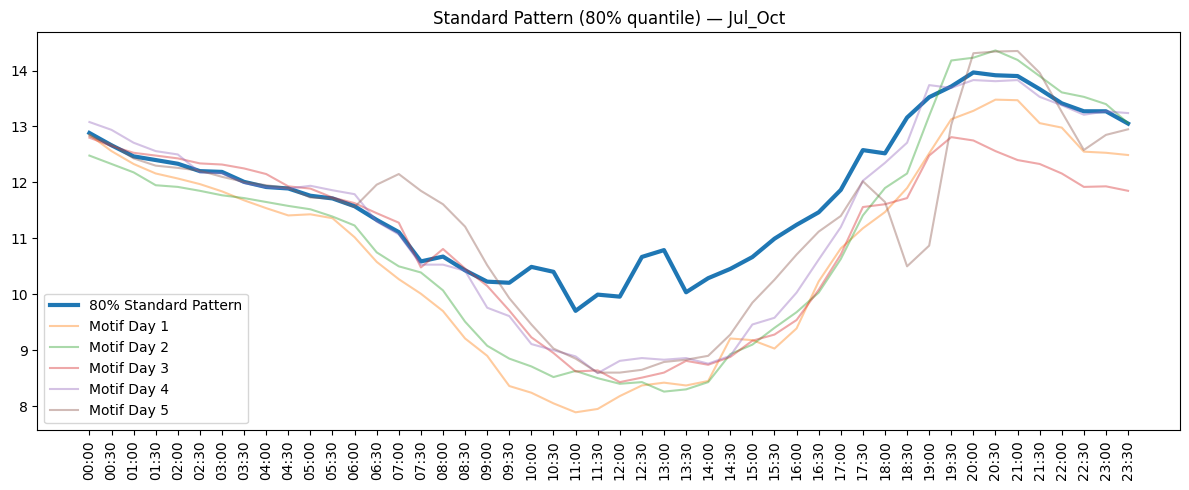


=== Processing motif for Nov_Feb ===
Saved standard pattern to: /content/drive/MyDrive/BTP/standard_pattern_Nov_Feb.csv


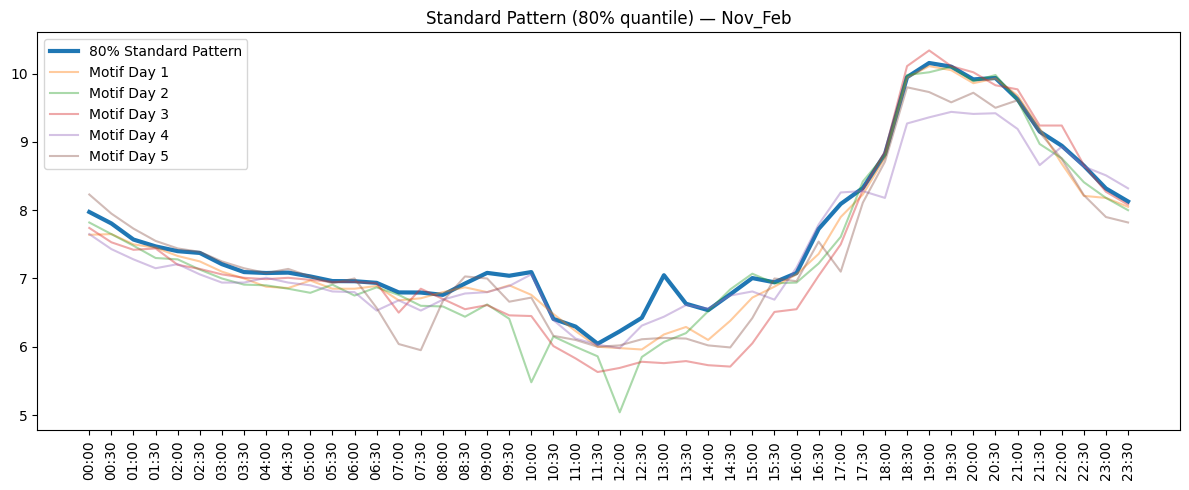


=== Processing motif for Mar_Jun ===
Saved standard pattern to: /content/drive/MyDrive/BTP/standard_pattern_Mar_Jun.csv


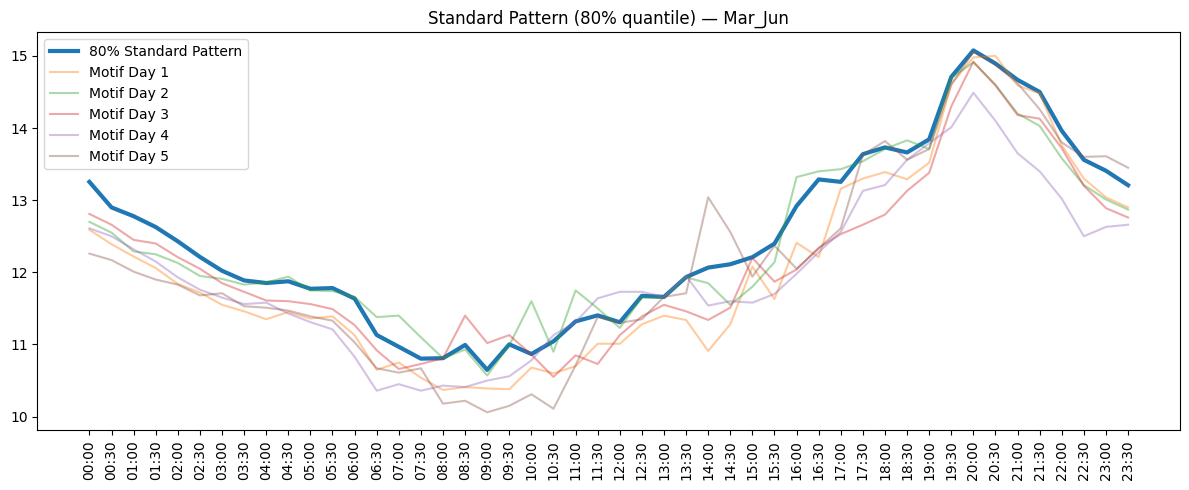

In [28]:
# STEP 5: Build Standard Pattern (80% Quantile) from Motif Groups
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

motif_dir = '/content/drive/MyDrive/BTP/'
out_dir = '/content/drive/MyDrive/BTP/'

segments = ['Jul_Oct', 'Nov_Feb', 'Mar_Jun']

# Time labels (matching 48 half-hour intervals)
time_labels = pd.date_range('00:00','23:30',freq='30min').strftime('%H:%M').tolist()

for seg in segments:
    motif_file = os.path.join(motif_dir, f'motif_group_{seg}.csv')

    if not os.path.exists(motif_file):
        print(f"Skipping {seg} (no motif group file found).")
        continue

    print(f"\n=== Processing motif for {seg} ===")

    # Load motif days (48 columns + date)
    df = pd.read_csv(motif_file)

    # Keep only the numeric 48 columns
    numeric_df = df[time_labels].astype(float)

    # Compute 80th percentile across motif days → axis=0 (per time-of-day)
    standard_pattern = numeric_df.quantile(0.80, axis=0)

    # Save to CSV
    out_path = os.path.join(out_dir, f'standard_pattern_{seg}.csv')
    standard_pattern.to_csv(out_path, header=['Load(KWH)'])
    print(f"Saved standard pattern to: {out_path}")

    # ---- Optional: Quick Plot ----
    plt.figure(figsize=(12,5))
    plt.plot(standard_pattern.values, linewidth=3, label="80% Standard Pattern")

    # plot up to 5 sample motif days for comparison
    for i in range(min(5, len(numeric_df))):
        plt.plot(numeric_df.iloc[i].values, alpha=0.4, label=f"Motif Day {i+1}")

    plt.xticks(ticks=range(48), labels=time_labels, rotation=90)
    plt.title(f"Standard Pattern (80% quantile) — {seg}")
    plt.legend()
    plt.tight_layout()
    plt.show()



=== Processing fluctuation for Jul_Oct ===
Saved: /content/drive/MyDrive/BTP/P_fluct_Jul_Oct.csv


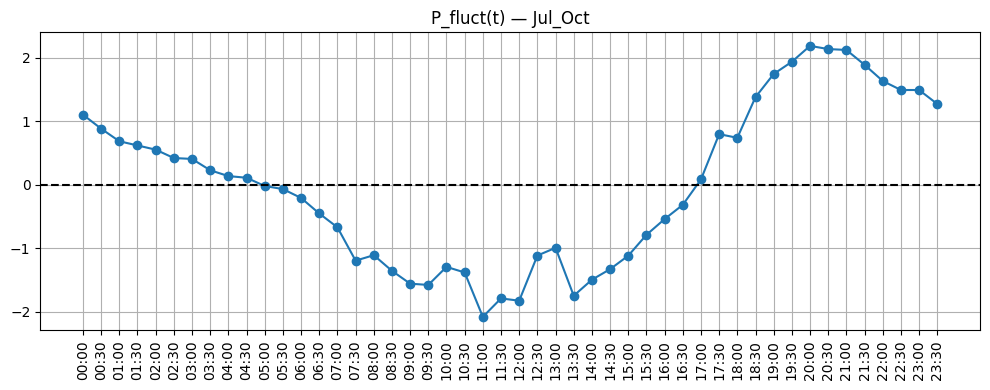


=== Processing fluctuation for Nov_Feb ===
Saved: /content/drive/MyDrive/BTP/P_fluct_Nov_Feb.csv


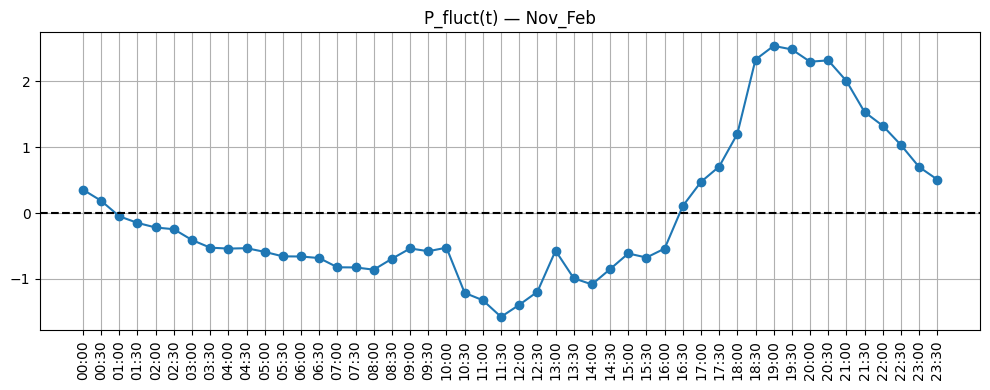


=== Processing fluctuation for Mar_Jun ===
Saved: /content/drive/MyDrive/BTP/P_fluct_Mar_Jun.csv


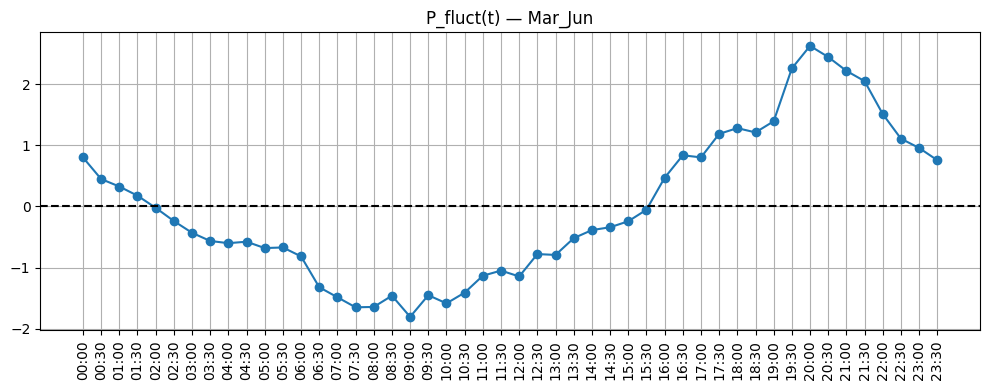

In [31]:
# STEP 6 (Final): Compute fluctuation profile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

base_dir = "/content/drive/MyDrive/BTP/"
segments = ["Jul_Oct", "Nov_Feb", "Mar_Jun"]

# 48 half-hour labels
time_labels = pd.date_range('00:00','23:30',freq='30min').strftime('%H:%M').tolist()

for seg in segments:
    std_file = os.path.join(base_dir, f"standard_pattern_{seg}.csv")

    if not os.path.exists(std_file):
        print(f"Skipping {seg}: no standard pattern found.")
        continue

    print(f"\n=== Processing fluctuation for {seg} ===")

    # Load standard pattern — now correctly reading BOTH columns
    sp = pd.read_csv(std_file)

    # Detect the numeric column automatically
    numeric_col = [c for c in sp.columns if c.lower().startswith("load") or "kwh" in c.lower()]
    if len(numeric_col) == 0:
        raise ValueError("No numeric Load column found in file!")
    numeric_col = numeric_col[0]

    # Extract numeric values
    standard_pattern = sp[numeric_col].astype(float).values

    if len(standard_pattern) != 48:
        print(f"WARNING: expected 48 values, got {len(standard_pattern)}")

    # Step 6.1: Daily average
    P_avg = np.mean(standard_pattern)

    # Step 6.2: Fluctuation profile
    P_fluct = standard_pattern - P_avg

    # Save output
    out_file = os.path.join(base_dir, f"P_fluct_{seg}.csv")
    pd.DataFrame({"time": time_labels, "P_fluct": P_fluct}).to_csv(out_file, index=False)
    print("Saved:", out_file)

    # Optional Plot
    plt.figure(figsize=(10,4))
    plt.plot(P_fluct, marker='o')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"P_fluct(t) — {seg}")
    plt.xticks(range(48), time_labels, rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [32]:
# STEP 7: Battery Sizing According to Paper Equations
import pandas as pd
import numpy as np
import os

base_dir = "/content/drive/MyDrive/BTP/"
segments = ["Jul_Oct", "Nov_Feb", "Mar_Jun"]

eta = 0.9            # one-way efficiency
SOC_min = 0.10
SOC_max = 0.90
dt_hours = 0.5       # 30 minutes = 0.5 hour

results = []

for seg in segments:
    fpath = os.path.join(base_dir, f"P_fluct_{seg}.csv")
    if not os.path.exists(fpath):
        print(f"Skipping {seg} (file missing)")
        continue

    print(f"\n=== Sizing Battery for {seg} ===")

    df = pd.read_csv(fpath)
    P_fluct = df["P_fluct"].values.astype(float)

    # ----------------------------
    # 1) R(t) = η^(-sgn(P_fluct(t))) * P_fluct(t)
    # ----------------------------
    R = []
    for p in P_fluct:
        if p > 0:       # discharge → efficiency loss
            R.append(p / eta)
        elif p < 0:     # charge → multiplied by eta
            R.append(p * eta)
        else:
            R.append(0.0)
    R = np.array(R)

    # ----------------------------
    # 2) Nominal Power (Pn)
    # ----------------------------
    Pn = np.max(np.abs(R))

    # ----------------------------
    # 3) Nominal Capacity (En)
    # E(t) = sum(R(t)) * dt
    # En = (max(E) - min(E)) / (SOC_max - SOC_min)
    # ----------------------------
    E = np.cumsum(R * dt_hours)      # integration
    En = (np.max(E) - np.min(E)) / (SOC_max - SOC_min)

    # ----------------------------
    # 4) Max Ramp Rate (Rn)
    # Rn = max |R(t) - R(t-1)| / dt
    # Units: kW per hour → divide by dt=0.5h → kW/h
    # If you want kW/s, divide by 3600.
    # ----------------------------
    dR = np.diff(R)
    Rn = np.max(np.abs(dR)) / dt_hours   # kW/hour

    # ----------------------------
    # 5) Number of mode changes
    # count sign changes (charging ↔ discharging)
    # ----------------------------
    signs = np.sign(R)
    mode_changes = np.sum(signs[1:] * signs[:-1] < 0)

    # Store results
    results.append({
        "segment": seg,
        "Pn_kW": Pn,
        "En_kWh": En,
        "Max_ramp_kW_per_hour": Rn,
        "Mode_changes": mode_changes
    })

# ----------------------------
# Save results
# ----------------------------
results_df = pd.DataFrame(results)
out_path = os.path.join(base_dir, "battery_sizing_results.csv")
results_df.to_csv(out_path, index=False)

print("\nSaved battery sizing results to:", out_path)
print("\n--- RESULTS ---")
print(results_df)



=== Sizing Battery for Jul_Oct ===

=== Sizing Battery for Nov_Feb ===

=== Sizing Battery for Mar_Jun ===

Saved battery sizing results to: /content/drive/MyDrive/BTP/battery_sizing_results.csv

--- RESULTS ---
   segment     Pn_kW     En_kWh  Max_ramp_kW_per_hour  Mode_changes
0  Jul_Oct  2.426343  14.630062              1.582222             2
1  Nov_Feb  2.819352  14.971701              2.506667             2
2  Mar_Jun  2.915231  16.031481              1.920000             2


In [33]:
import pandas as pd
import numpy as np

# Load the results created earlier
results_path = "/content/drive/MyDrive/BTP/battery_sizing_results.csv"
df = pd.read_csv(results_path)

print("\n=== RAW SIZING RESULTS FROM SEGMENTS ===")
print(df)

# Step 1: Pick the maximum required values across the 3 segments
Pn_required = df["Pn_kW"].max()
En_required = df["En_kWh"].max()

# Step 2: Recommended margins (because no flywheel)
# 50% inverter power margin (handle fast spikes)
Pn_final = Pn_required * 1.5

# 20% energy margin (for ageing + bad days)
En_final = En_required * 1.20

# Step 3: Round to practical numbers
Pn_final_rounded = round(Pn_final, 1)          # kW
En_final_rounded = round(En_final)             # kWh

print("\n=== FINAL BATTERY SIZE (NO FLYWHEEL) ===")
print(f"→ Max required Pn = {Pn_required:.3f} kW")
print(f"→ Max required En = {En_required:.3f} kWh\n")

print(f"Recommended inverter power (Pn_final) = {Pn_final_rounded} kW")
print(f"Recommended battery capacity (En_final) = {En_final_rounded} kWh")

# Save final result
out = pd.DataFrame({
    "Pn_required_kW":[Pn_required],
    "En_required_kWh":[En_required],
    "Pn_final_kW":[Pn_final_rounded],
    "En_final_kWh":[En_final_rounded]
})
out_path = "/content/drive/MyDrive/BTP/final_battery_size_no_flywheel.csv"
out.to_csv(out_path, index=False)

print("\nSaved final battery spec to:", out_path)



=== RAW SIZING RESULTS FROM SEGMENTS ===
   segment     Pn_kW     En_kWh  Max_ramp_kW_per_hour  Mode_changes
0  Jul_Oct  2.426343  14.630062              1.582222             2
1  Nov_Feb  2.819352  14.971701              2.506667             2
2  Mar_Jun  2.915231  16.031481              1.920000             2

=== FINAL BATTERY SIZE (NO FLYWHEEL) ===
→ Max required Pn = 2.915 kW
→ Max required En = 16.031 kWh

Recommended inverter power (Pn_final) = 4.4 kW
Recommended battery capacity (En_final) = 19 kWh

Saved final battery spec to: /content/drive/MyDrive/BTP/final_battery_size_no_flywheel.csv


In [34]:
import pandas as pd
import numpy as np
import os

base = "/content/drive/MyDrive/BTP/"
segments = ["Jul_Oct", "Nov_Feb", "Mar_Jun"]

# parameters (must match what we used)
eta = 0.9
SOC_min = 0.10
SOC_max = 0.90
dt_h = 0.5   # hours per slot

# load final recommended battery capacity (nameplate kWh)
final_spec_path = os.path.join(base, "final_battery_size_no_flywheel.csv")
spec = pd.read_csv(final_spec_path)
En_final_kWh = float(spec['En_final_kWh'].iloc[0])   # recommended pack size (kWh)
Pn_final_kW = float(spec['Pn_final_kW'].iloc[0])     # recommended inverter power (kW)

print("Final recommended pack (nameplate):", En_final_kWh, "kWh")
print("Recommended inverter power:", Pn_final_kW, "kW\n")

for seg in segments:
    f = os.path.join(base, f"P_fluct_{seg}.csv")
    if not os.path.exists(f):
        print("Missing", f, "— skipping", seg); continue

    df = pd.read_csv(f)   # columns: time, P_fluct (kWh per 30min)
    # ensure numeric and correct length
    df = df.copy()
    # detect numeric column name
    pcol = [c for c in df.columns if c.lower().startswith("p_fl") or "fluct" in c.lower()]
    if not pcol:
        pcol = [c for c in df.columns if c != df.columns[0]]
    pcol = pcol[0]
    df['P_fluct_kWh'] = df[pcol].astype(float).values

    # convert to average power in kW for the 30-min slot
    df['P_kW'] = df['P_fluct_kWh'] / dt_h

    # apply efficiency to get R_kW (battery-side power: positive -> discharge, negative -> charge)
    def R_of_p(p_kwh):
        # p_kwh is energy in slot (kWh)
        p_kw = p_kwh / dt_h
        if p_kw > 0:
            return p_kw / eta   # discharge
        elif p_kw < 0:
            return p_kw * eta   # charge (more negative magnitude)
        else:
            return 0.0

    df['R_kW'] = df['P_fluct_kWh'].apply(R_of_p)

    # energy moved by battery during each 30-min slot (kWh) = R_kW * dt_h
    df['E_slot_kWh'] = df['R_kW'] * dt_h

    # cumulative energy trajectory (E(t)) starting from zero reference
    df['E_cum_kWh'] = df['E_slot_kWh'].cumsum()

    # compute required En from this series (for sanity)
    En_calc = (df['E_cum_kWh'].max() - df['E_cum_kWh'].min()) / (SOC_max - SOC_min)

    # compute SOC used relative to recommended pack
    # usable energy of pack at SOC window = En_final_kWh * (SOC_max - SOC_min)
    usable_pack_kWh = En_final_kWh * (SOC_max - SOC_min)
    # map cumulative E to SOC position within usable window:
    # normalize E_cum so that min->0, max->usable_pack_kWh
    e_min = df['E_cum_kWh'].min()
    e_max = df['E_cum_kWh'].max()
    if np.isclose(e_max, e_min):
        df['SOC_used'] = 0.0
    else:
        df['SOC_used'] = (df['E_cum_kWh'] - e_min) / (e_max - e_min)  # 0..1 fraction of usable window
        # convert to absolute SOC (0..1) w.r.t full pack using SOC_min..SOC_max
        df['SOC_absolute'] = SOC_min + df['SOC_used'] * (SOC_max - SOC_min)

    # Save per-segment detailed CSV
    out = os.path.join(base, f"battery_slot_detail_{seg}.csv")
    df_out = df[['time', 'P_fluct_kWh','P_kW','R_kW','E_slot_kWh','E_cum_kWh','SOC_used','SOC_absolute']].copy()
    df_out.to_csv(out, index=False)

    # Print summary
    print(f"Segment: {seg}")
    print("  computed En (from E_cum)  = {:.3f} kWh".format(En_calc))
    print("  recommended pack size used = {:.1f} kWh (nameplate)".format(En_final_kWh))
    print("  usable pack energy (10-90%) = {:.3f} kWh".format(usable_pack_kWh))
    print("  E_cum min/max (kWh): {:.4f} / {:.4f}".format(e_min, e_max))
    print("  saved per-slot detail ->", out)
    print()

print("Done.")


Final recommended pack (nameplate): 19.0 kWh
Recommended inverter power: 4.4 kW

Segment: Jul_Oct
  computed En (from E_cum)  = 29.260 kWh
  recommended pack size used = 19.0 kWh (nameplate)
  usable pack energy (10-90%) = 15.200 kWh
  E_cum min/max (kWh): -17.7025 / 5.7056
  saved per-slot detail -> /content/drive/MyDrive/BTP/battery_slot_detail_Jul_Oct.csv

Segment: Nov_Feb
  computed En (from E_cum)  = 29.943 kWh
  recommended pack size used = 19.0 kWh (nameplate)
  usable pack energy (10-90%) = 15.200 kWh
  E_cum min/max (kWh): -19.2887 / 4.6660
  saved per-slot detail -> /content/drive/MyDrive/BTP/battery_slot_detail_Nov_Feb.csv

Segment: Mar_Jun
  computed En (from E_cum)  = 32.063 kWh
  recommended pack size used = 19.0 kWh (nameplate)
  usable pack energy (10-90%) = 15.200 kWh
  E_cum min/max (kWh): -20.4072 / 5.2432
  saved per-slot detail -> /content/drive/MyDrive/BTP/battery_slot_detail_Mar_Jun.csv

Done.
